In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.optimize import minimize
import cvxpy as cp
np.random.seed(592)

Here is the optimization code to compute the argmax over the continuous action space:

In [3]:
def get_objective_function(beta_t, cov, theta_hat):
    
    def objective_func(a):
        a = np.asarray(a)
        inner_prod = np.dot(-theta_hat, a)
        cov_inv = np.linalg.inv(cov)
        bonus_term = np.dot(a, np.dot(cov_inv, a)) * beta_t
        total = inner_prod + bonus_term
        return total
    
    return objective_func
                           

def get_optimal_action_oful_p1(beta_t, cov, theta_hat, d):
    """
    Get the optimal action based on the current estimate of theta and the covariance matrix.
    The action a must lie on or within the d-dimensional unit ball: ||a||_2 <= 1.
    """
    # Get the objective function
    objective_func = get_objective_function(beta_t, cov, theta_hat)

    # Initial guess: unit vector in random direction
    a0 = np.random.uniform(-1, 1, d)
    # Normalize the initial guess to ensure it starts within the unit ball
    a0 /= np.linalg.norm(a0)

    # Define the constraint: ||a||_2 <= 1
    constraint = {
        'type': 'ineq',
        'fun': lambda a: 1 - np.linalg.norm(a)  # 1 - ||a||_2 >= 0
    }

    # Optional: bounds to keep values in a reasonable range (e.g., [-1, 1])
    bounds = [(-1, 1) for _ in range(d)]

    # Solve the optimization problem
    result = minimize(
        objective_func,
        x0=a0,
        bounds=bounds,
        method='SLSQP',
        constraints=[constraint]
    )

    if result.success:
        return result.x
    else:
        raise ValueError("Optimization failed:", result.message)

def get_optimal_action_oful_p1(beta_t, cov, theta_hat, d, solver=cp.SCS):
    """
    Get the optimal action using cvxpy with specified solver.
    
    Parameters:
    - beta_t: scalar coefficient
    - cov: covariance matrix (d x d)
    - theta_hat: estimate of theta (d,)
    - d: dimensionality of action vector
    - solver: cvxpy solver to use (default is cp.SCS)
    """
    a = cp.Variable(d)
    cov_inv = np.linalg.inv(cov)

    inner_prod = -theta_hat @ a
    bonus_term = beta_t * cp.quad_form(a, cov_inv)
    objective = cp.Minimize(inner_prod + bonus_term)
    constraints = [cp.norm(a, 2) <= 1]

    prob = cp.Problem(objective, constraints)
    prob.solve(solver=solver)

    if a.value is not None:
        return a.value
    else:
        raise ValueError("CVXPY optimization failed.")


def get_optimal_action(theta, d):
    """
    Get the optimal action based on theta and action set is the unit ball in d dimensions.
    """
    def objective_func(a):
        a = np.asarray(a)
        inner_prod = np.dot(theta, a)
        return -1 * inner_prod
 
    # Initial guess: unit vector in one direction
    a0 = np.zeros(d)
    a0[0] = 1.0  # could also try random or uniform initialization

    # Define the constraint: ||a||_2 <= 1
    constraint = {
        'type': 'ineq',
        'fun': lambda a: 1 - np.linalg.norm(a)  # 1 - ||a||_2 >= 0
    }

    # Optional: bounds to keep values in a reasonable range (e.g., [-1, 1])
    bounds = [(-1, 1) for _ in range(d)]

    # Solve the optimization problem
    result = minimize(
        objective_func,
        x0=a0,
        bounds=bounds,
        constraints=[constraint]
    )

    if result.success:
        return result.x
    else:
        raise ValueError("Optimization failed:", result.message)

OFUL implementation for continuous action space: 

In [5]:
def oful_p1(reg_parameter, d, horizon, theta, optimal_action, num_simulations):
    """
    - Implementation of the OFUL algorithm where action space is a d-dimensional ball of radius 1.
    - Ground truth theta is a d-dimensional vector
    """
    
    regrets = np.zeros(num_simulations)

    for i in tqdm(range(num_simulations)):
        # Initialize variables
        cov = np.eye(d) * reg_parameter
        theta_hat = np.zeros(d)

        #mantain a list of vectors of rt*at
        action_rewards = []
        regret = 0
    
        for t in range(1, horizon+1):
            beta_t = np.sqrt(d * np.log(t*horizon))
            action = -1 * get_optimal_action_oful_p1(beta_t, cov, theta_hat, d)

            # Observe the reward
            reward = np.dot(theta, action) #+ np.random.normal(0, .1)

            # Update the covariance matrix and theta_hat
            cov += np.outer(action, action)
            action_rewards.append(action*reward)
            theta_hat = np.linalg.inv(cov).dot(np.sum(action_rewards, axis=0))

            # Calculate the regret
            regret += np.dot(theta, optimal_action) - np.dot(theta, action)

        print(action)
        print(np.linalg.norm(action))

        regrets[i] = regret

    return regrets

In [6]:
# try 5-d case where all elements of theta are 1/5
d = 5
theta = np.ones(d)*1/5
optimal_action = get_optimal_action(theta, d)
reg_parameter = 1
horizon = 1000
num_simulations = 1

regrets = oful_p1(reg_parameter, d, horizon, theta, optimal_action, num_simulations)

  0%|          | 0/1 [00:00<?, ?it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


100%|██████████| 1/1 [00:08<00:00,  8.74s/it]

[-0. -0. -0. -0. -0.]
0.0


In [7]:
print("Optimal action:", optimal_action)
print("theta:", theta)

Optimal action: [0.44721299 0.44721375 0.44721375 0.44721374 0.44721375]
theta: [0.2 0.2 0.2 0.2 0.2]


Looks like the optimization code with scipy is not working. Here is the implementation of OFUL and UCB over the discrete action space: 

In [8]:
def get_optimal_action_oful_p2(beta_t, cov, theta_hat, action_set):
    """
    Get the optimal action based on the current estimate of theta and the covariance matrix.
    The action is in the discrete action set
    """

    def objective_func(a):
        a = np.asarray(a)
        inner_prod = np.dot(theta_hat, a)
        cov_inv = np.linalg.inv(cov)
        bonus_term = np.sqrt(np.dot(a, np.dot(cov_inv, a))) * beta_t
        total = inner_prod + bonus_term
        return total

    #try all actions in the action set and return the one that maximizes the objective_func 
    best_action = None
    best_value = -np.inf
    for action in action_set:
        value = objective_func(action)
        if value > best_value:
            best_value = value
            best_action = action

    return best_action

In [9]:
def oful_p2(reg_parameter, action_set, horizon, theta, optimal_action, num_simulations):
    """
    - Implementation of the OFUL algorithm where action space is discrete
    """
    d = action_set.shape[1]

    regrets = np.zeros(num_simulations)

    for i in tqdm(range(num_simulations)):
        # Initialize variables
        cov = np.eye(d) * reg_parameter
        theta_hat = np.zeros(d)

        #mantain a list of vectors of rt*at
        action_rewards = []
        regret = 0
    
        for t in range(1, horizon+1):
            beta_t = np.sqrt(d * np.log(t * horizon))

            action = get_optimal_action_oful_p2(beta_t, cov, theta_hat, action_set)

            # Observe the reward
            reward = np.dot(theta, action) + np.random.normal(0, 0.5)

            # Update the covariance matrix and theta_hat
            cov += np.outer(action, action)
            action_rewards.append(action*reward)
            theta_hat = np.linalg.inv(cov).dot(np.sum(action_rewards, axis=0))

            # Calculate the regret
            regret += np.dot(theta, optimal_action) - np.dot(theta, action)

        regrets[i] = regret

    return regrets

In [83]:
def ucb_p2(action_set, horizon, theta, optimal_action, num_simulations):
    """
    UCB for discrete action set where each action is an arm 
    """
    regret = np.zeros(num_simulations)

    for i in tqdm(range(num_simulations)):

        # Initialize variables
        action_rewards = np.zeros(len(action_set))
        action_counts = np.zeros(len(action_set))

        regret_i = 0

        #pull each arm once 
        for j in range(len(action_set)):
            action = action_set[j]
            reward = np.dot(theta, action) + np.random.normal(0, 0.5)
            action_rewards[j] = reward
            action_counts[j] += 1
            regret_i += np.dot(theta, optimal_action) - np.dot(theta, action)

        for t in range(len(action_set), horizon):
            # Calculate the upper confidence bound for each action
            ucb = action_rewards / action_counts + np.sqrt(2 * np.log(2*(horizon**2)*len(action_set)) / action_counts)

            # Select the action with the highest UCB
            action = action_set[np.argmax(ucb)]

            # Observe the reward
            reward = np.dot(theta, action) + np.random.normal(0, 0.5)
            action_rewards[np.argmax(ucb)] += reward
            action_counts[np.argmax(ucb)] += 1

            # Calculate the regret
            regret_i += np.dot(theta, optimal_action) - np.dot(theta, action)

        regret[i] = regret_i

    return regret
    

100%|██████████| 5/5 [00:01<00:00,  3.74it/s]


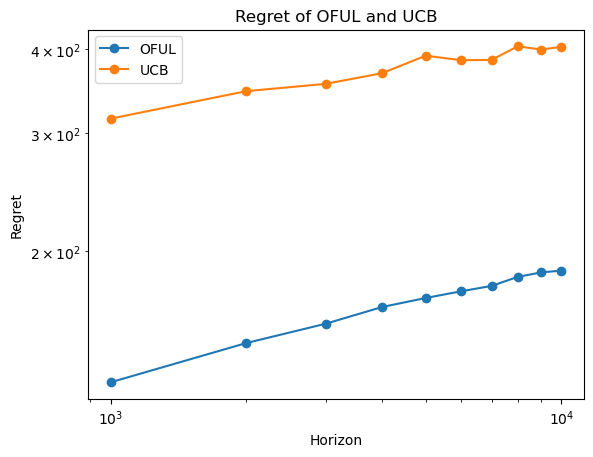

In [78]:
#Plot regret of oful_p2 and ucb_p2 on the same plot for different horizons 

action_set = np.array(list(np.ndindex(*([2]*5)))) * 2 - 1
theta = np.array([1, -1, 1, -1, 1])
optimal_action = theta
reg_parameter = 1
num_simulations = 5
horizons = np.linspace(10**3, 10**4, 10).astype(int)

regrets_oful = []
regrets_ucb = []

for horizon in horizons:
    regrets_oful.append(np.mean(oful_p2(reg_parameter, action_set, horizon, theta, optimal_action, num_simulations)))
    regrets_ucb.append(np.mean(ucb_p2(action_set, horizon, theta, optimal_action, num_simulations)))

plt.plot(horizons, regrets_oful, label='OFUL', marker='o')
plt.plot(horizons, regrets_ucb, label='UCB', marker='o')
plt.xlabel('Horizon')
plt.ylabel('Regret')
plt.title('Regret of OFUL and UCB')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.show()